# visualizing bounding-box around Zooplankton in an image

In [2]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 84.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.0/221.0 kB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 91.8 MB/s eta 0:00:00:00:0100:01


In [3]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from PIL import Image
from sklearn.cluster import KMeans
from skimage import io
from io import StringIO


In [ ]:
plt.ion()

In [9]:
boundingbox_frames = pd.read_csv('annotations/8/annotations_8.csv')
image_folder='dataset/All_Images/2022-09-08'

In [10]:
boundingbox_frames = boundingbox_frames.rename(columns={'# 1: Detection or Track-id':'Track-id',
                                                        '2: Video or Image Identifier':'Image Identifier',
                                                        '4-7: Img-bbox(TL_x':'TL_x',
                                                        'BR_y)':'BR_y',
                                                        '8: Detection or Length Confidence':'Length Confidence',
                                                        '9: Target Length (0 or -1 if invalid)':'Target Length',
                                                        '10-11+: Repeated Species':'Repeated Species',
                                                        'Confidence Pairs or Attributes':'Attributes',
                                                        'Unnamed: 11':'poly_cordinates'})

In [11]:
boundingbox_frames.columns

Index(['Track-id', 'Image Identifier', '3: Unique Frame Identifier', 'TL_x',
       'TL_y', 'BR_x', 'BR_y', 'Length Confidence', 'Target Length',
       'Repeated Species', 'Attributes', 'poly_cordinates'],
      dtype='object')

In [12]:
n = 260
img_name = boundingbox_frames.iloc[n,1]
bounding_box = boundingbox_frames.iloc[n,11]
bounding_box = np.asarray(bounding_box.split())[1:]
bounding_box = bounding_box.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Bounding box shape: {}'.format(bounding_box.shape))
print('First 4 points: {}'.format(bounding_box[:4]))

Image name: soloAUV 20220908-222629-1057.png
Bounding box shape: (9, 2)
First 4 points: [[ 971. 1370.]
 [1080. 1192.]
 [1191.  958.]
 [1147.  942.]]


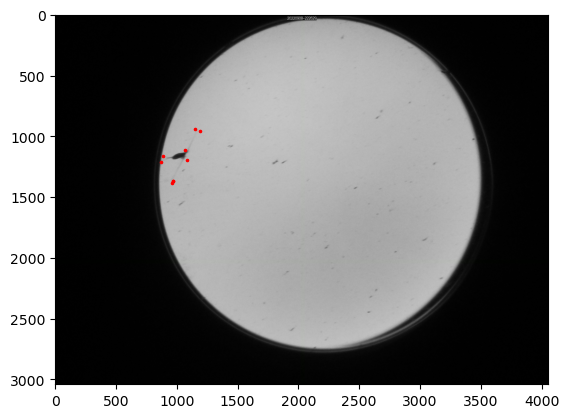

In [13]:
def show_boundingbox(image, bbox):
    plt.imshow(image)
    plt.scatter(bbox[:,0], bbox[:,1], s=10, marker='.', c='r')
    plt.pause(0.001)
    
plt.figure()
show_boundingbox(io.imread(os.path.join(image_folder,img_name)),bounding_box)
plt.show()


copepod


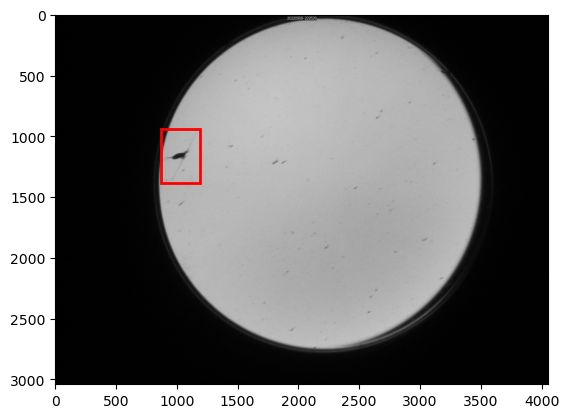

In [14]:
select_columns = ['TL_x','TL_y', 'BR_x', 'BR_y','Repeated Species']
b_box = boundingbox_frames.loc[n,select_columns]

def show_AOI(image,TL_x,TL_y,BR_x,BR_y):
    plt.imshow(image)
    rect = patches.Rectangle((TL_x,TL_y), (BR_x-TL_x), (BR_y-TL_y), linewidth=2, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)
    plt.show()
    
print(b_box['Repeated Species'])
show_AOI(io.imread(os.path.join(image_folder,img_name)),b_box['TL_x'],b_box['TL_y'],b_box['BR_x'],b_box['BR_y'])

After analysis of bounding boxes, we can say that columns 'TL_x','TL_y', 'BR_x', 'BR_y' are collinear with column poly_cordinates, so we can use either one for training because of collinearity.

# Class value counts

In [141]:
# for folder 8 
label.value_counts()

0    11012
1     1734
Name: Label, dtype: int64

In [123]:
#for folder 11
label.value_counts()

0    1032
1     284
Name: Label, dtype: int64

In [132]:
#for folder 19
label.value_counts()

0    8172
1    1442
Name: Label, dtype: int64

In [138]:
#for folder all
#12794
label.value_counts()

0    11012
1     1734
Name: Label, dtype: int64

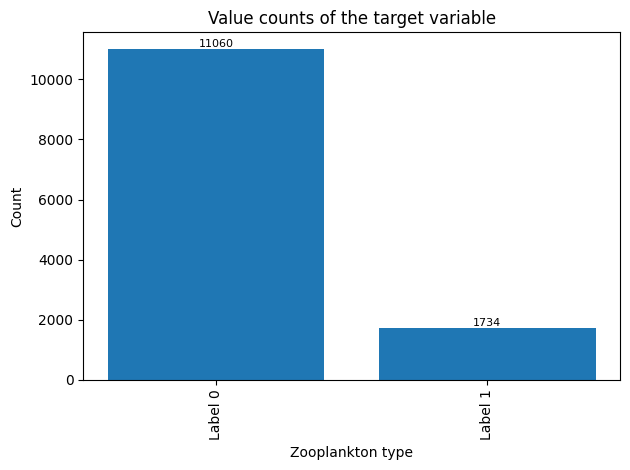

In [140]:
import matplotlib.pyplot as plt

# Assuming you already have boundingbox_frames and label defined

class_counts = label.value_counts()

plt.bar(class_counts.index, class_counts.values)
plt.title("Value counts of the target variable")
plt.xlabel("Zooplankton type")
plt.ylabel("Count")

# Adding text labels on top of the bars
for i, count in enumerate(class_counts):
    label_text = str(count)
    if class_counts.index[i] == 0:  # Change label 9 to 11060
        label_text = '11060'
    plt.text(i, count + 5, label_text, ha='center', va='bottom', fontsize=8, color='black')

# Manipulate x-axis ticks
plt.xticks(class_counts.index, ["Label 0", "Label 1"] + list(class_counts.index[2:]), rotation='vertical')

plt.tight_layout()
plt.show()


In [86]:
label=boundingbox_frames['Repeated Species']
class_counts = label.value_counts().plot(kind="bar")
plt.title("Value counts of the target variable")
plt.xlabel("Zooplankton type")
plt.xticks(rotation='vertical')
plt.ylabel("Count")
plt.show()

As there are many classes, for binary classification which class should I make '0' or 'No Zooplankton'. Is it unknown or the ones with maybe?

# Normalizing images

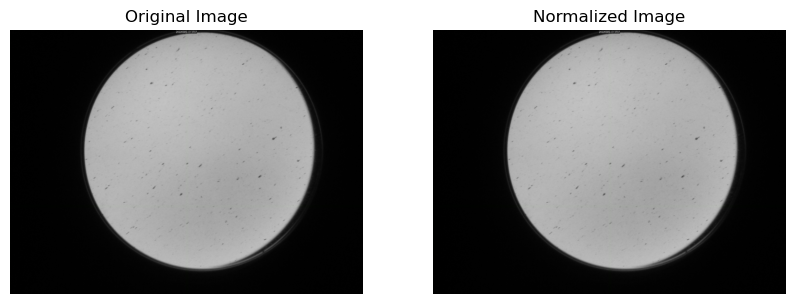

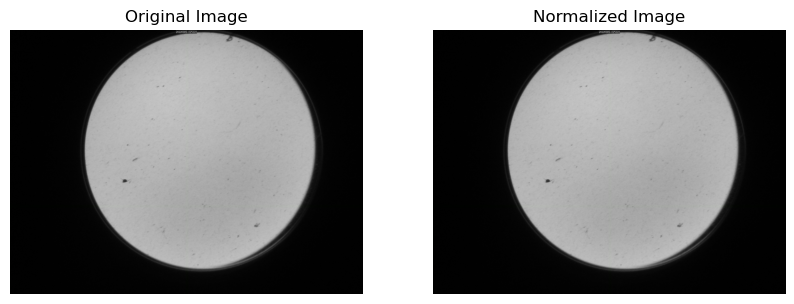

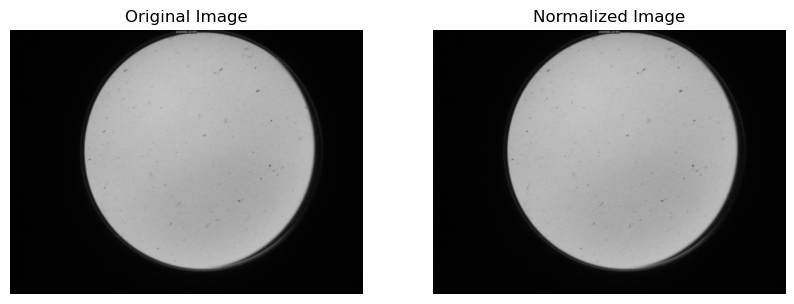

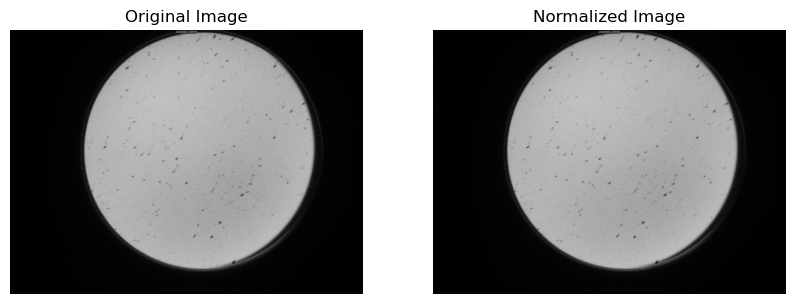

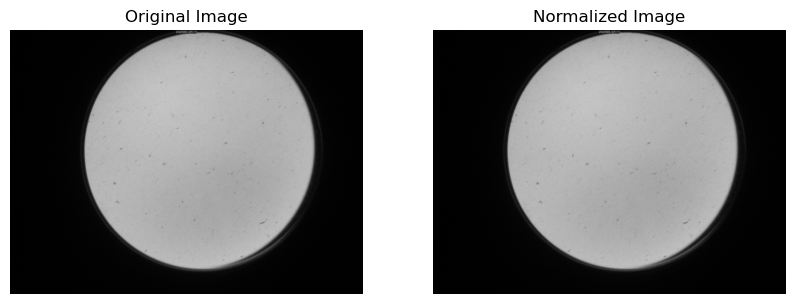

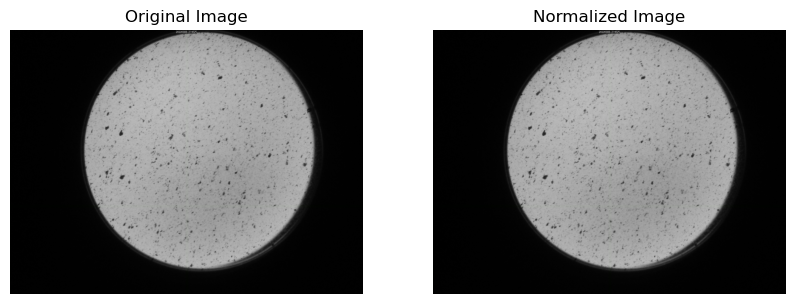

In [11]:
from PIL import Image

def normalize_image(image):
    image_array = np.array(image)
    normalized_image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
    normalized_image = Image.fromarray((normalized_image_array * 255).astype(np.uint8))
    return normalized_image

counter = 0
# Iterate through the images in the folder
for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        counter += 1
        image_path = os.path.join(image_folder, filename)

        # Open and normalize the image
        image = io.imread(image_path)
        normalized_image = normalize_image(image)

        # Display the original and normalized images
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Original Image')
        axs[0].axis('off')
        axs[1].imshow(normalized_image)
        axs[1].set_title('Normalized Image')
        axs[1].axis('off')

        # Show the plot
        plt.show()
        if counter > 5:
            break
        

# Creating custom Dataset class and DataLoader

In [87]:
class ZooplanktonDataset(Dataset):
    def __init__(self, csv, root_dir, transform=None):
        self.annotations = pd.read_csv(os.path.join(root_dir,csv))
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index,1])
        image = io.imread(img_path)
        #below is used to read image using PIL library
        # image = Image.open(img_path).convert('RGB')
        y_label = self.annotations.iloc[index,9]
                                
        if self.transform:
            image = self.transform(image)
        
        return (image,y_label)
                                
                          

In [88]:
dataset = ZooplanktonDataset(csv='result_2022_09_08.csv',root_dir='dataset/2022-09-08',
                            transform=transforms.ToTensor())

train_set, test_set = torch.utils.data.random_split(dataset, [500,133])

train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

0
torch.Size([1, 3, 3040, 4056])
('copepod',)
1
torch.Size([1, 3, 3040, 4056])
('copepod',)
2
torch.Size([1, 3, 3040, 4056])
('copepod',)
3
torch.Size([1, 3, 3040, 4056])
('copepod',)
4
torch.Size([1, 3, 3040, 4056])
('copepod',)
5
torch.Size([1, 3, 3040, 4056])
('copepod-edge',)
6
torch.Size([1, 4, 3040, 4056])


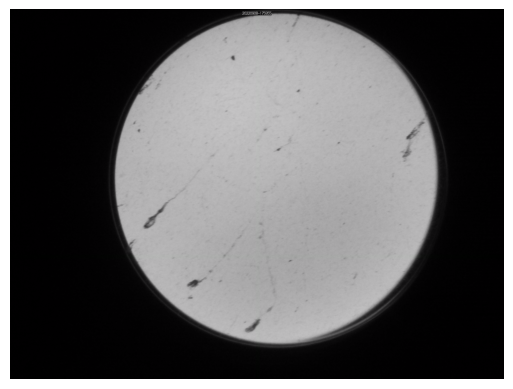

('marine-snow',)


In [89]:
for batch_idx, (data,targets) in enumerate(train_loader):
    print(batch_idx)
    print(data.shape)
    if data.shape[1] > 3:
        image_array = data.squeeze().numpy()

        image_array = image_array.transpose(1, 2, 0)

        plt.imshow(image_array)
        plt.axis('off')
        plt.show()
        print(targets)
        break
    print(targets)


with above experiment we found that there are few images with 4 dimension called alpha dimension of an image, the alpha channel represents the transparency or opacity of each pixel in the image. It defines the level of transparency for each pixel, allowing for smooth blending and overlay of images with different backgrounds.

# Clustering

In [1]:

class ZooplanktonDataset_Cropped(Dataset):
    def __init__(self, csv, root_dir, transform=None):
        self.annotations = pd.read_csv(os.path.join(root_dir, csv))
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = Image.open(img_path).convert('RGB')
        
        # Extract coordinates for area of interest from the CSV columns
        TL_x = self.annotations.iloc[index, 3]  # Top-left x-coordinate
        TL_y = self.annotations.iloc[index, 4]  # Top-left y-coordinate
        BR_x = self.annotations.iloc[index, 5]  # Bottom-right x-coordinate
        BR_y = self.annotations.iloc[index, 6]  # Bottom-right y-coordinate
                
        cropped_image = image.crop((TL_x, TL_y, BR_x, BR_y))
        
        y_label = self.annotations.iloc[index, 9]
                                
        if self.transform:
            cropped_image = self.transform(cropped_image)
        
        return (cropped_image, y_label)


NameError: name 'Dataset' is not defined

In [51]:
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ZooplanktonDataset_Cropped(csv='result_2022_09_08.csv',root_dir='dataset/2022-09-08',
                            transform=data_transform)

train_set, test_set = torch.utils.data.random_split(dataset, [500,133])

train_loader = DataLoader(dataset=train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0
torch.Size([1, 3, 400, 400])


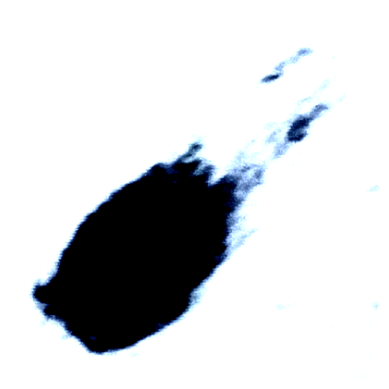

('marine-snow',)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1
torch.Size([1, 3, 400, 400])


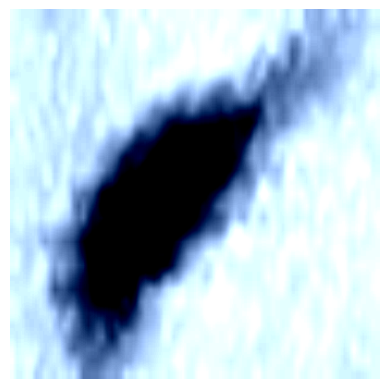

('copepod',)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


2
torch.Size([1, 3, 400, 400])


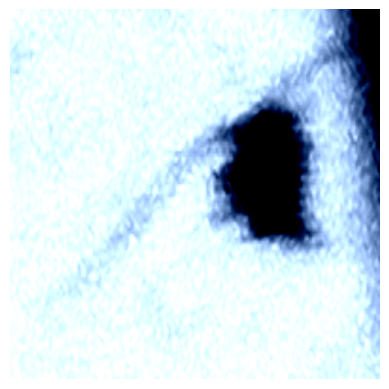

('copepod-edge',)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3
torch.Size([1, 3, 400, 400])


('copepod',)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4
torch.Size([1, 3, 400, 400])


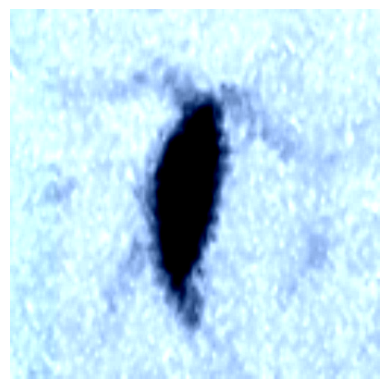

('copepod',)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5
torch.Size([1, 3, 400, 400])


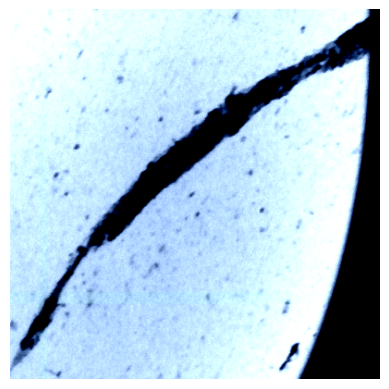

('marine-snow',)


KeyboardInterrupt: 

In [53]:
for batch_idx, (data,targets) in enumerate(train_loader):
    print(batch_idx)
    print(data.shape)
    if data.shape[1] > 2:
        image_array = data.squeeze().numpy()

        image_array = image_array.transpose(1, 2, 0)

        plt.imshow(image_array)
        plt.axis('off')
        plt.show()
    print(targets)


In [10]:
data_transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ZooplanktonDataset_Cropped(csv='result_2022_09_08.csv',root_dir=image_folder, transform=data_transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Prepare the data
images = []
labels = []
for batch_images, label in data_loader:
    batch_images = batch_images.view(batch_images.size(0), -1)
    images.append(batch_images)
    labels.append(label)

# Stack the batches into a single tensor
images = torch.cat(images, dim=0)

In [11]:
images.shape

torch.Size([633, 480000])

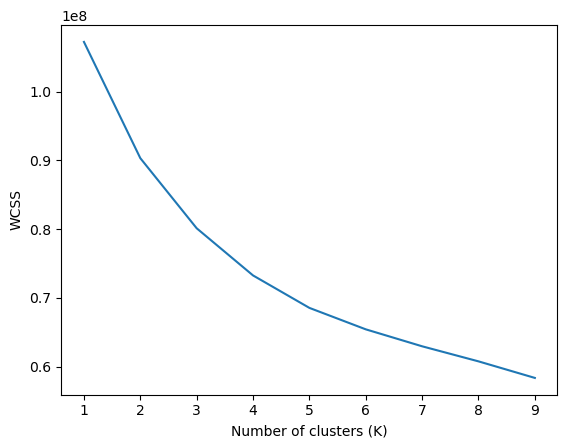

In [12]:
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(images)
    wcss.append(kmeans.inertia_)

# Plot the within-cluster sum of squares (WCSS) vs. K
import matplotlib.pyplot as plt
plt.plot(range(1, 10), wcss)
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

In [13]:
k_values = range(1, 10 + 1)
distances = [wcss[i] - wcss[i - 1] for i in range(1, len(wcss))]
best_k = distances.index(max(distances)) + 1

In [14]:
best_k

7

In [15]:
batches = labels
integer_labels = []

for batch in batches:
    # Find unique labels in the current batch
    unique_labels = list(set(batch))
    
    # Create a label map dictionary for the current batch
    label_map = {label: index for index, label in enumerate(unique_labels)}
    
    # Convert string labels to integer labels within the current batch
    integer_batch = [label_map[label] for label in batch]
    
    # Append the integer batch to the list of integer labels
    integer_labels.extend(integer_batch)

# Print the combined list of integer labels
print(integer_labels)

[2, 1, 1, 1, 1, 0, 4, 1, 1, 1, 4, 1, 1, 6, 1, 0, 1, 1, 4, 6, 6, 1, 1, 0, 1, 5, 3, 6, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 4, 1, 3, 2, 4, 1, 1, 2, 2, 4, 1, 1, 2, 1, 0, 0, 1, 1, 1, 4, 1, 1, 4, 1, 4, 1, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 4, 1, 0, 1, 3, 1, 1, 1, 1, 1, 4, 2, 1, 1, 0, 5, 4, 0, 4, 1, 1, 1, 2, 0, 1, 4, 1, 3, 4, 1, 1, 0, 1, 1, 0, 1, 3, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 4, 4, 1, 1, 0, 1, 4, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 4, 1, 4, 1, 1, 3, 1, 1, 4, 1, 1, 1, 6, 6, 1, 0, 6, 0, 6, 1, 3, 1, 6, 1, 2, 1, 1, 1, 5, 1, 1, 6, 1, 6, 1, 6, 3, 1, 3, 4, 1, 0, 3, 3, 2, 1, 2, 1, 0, 1, 2, 1, 1, 3, 5, 1, 2, 1, 1, 1, 5, 1, 1, 1, 1, 1, 3, 1, 4, 1, 0, 1, 2, 2, 1, 1, 1, 5, 0, 1, 3, 4, 3, 1, 3, 3, 1, 5, 0, 3, 1, 3, 1, 0, 1, 4, 5, 0, 1, 1, 1, 4, 1, 2, 1, 3, 1, 3, 7, 3, 3, 3, 3, 4, 3, 3, 3, 6, 3, 7, 3, 3, 0, 5, 4, 3, 3, 3, 2, 7, 7, 1, 3, 3, 8, 4, 3, 3, 3, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 6, 1, 2, 4, 1, 1, 6, 6, 1, 1, 1, 1, 1, 0, 1, 0, 3, 1, 1, 1, 1, 5, 4, 1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 

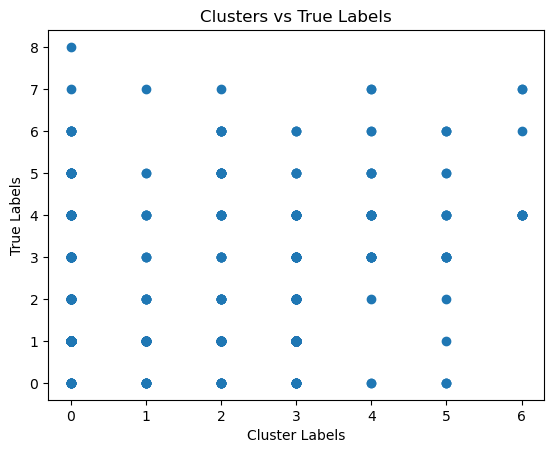

In [16]:
selected_k = best_k  # Update with the chosen value of K
kmeans = KMeans(n_clusters=selected_k, random_state=0)
kmeans.fit(images)

# Get the assigned labels
cluster_labels = kmeans.labels_

plt.scatter(cluster_labels, integer_labels)
plt.xlabel('Cluster Labels')
plt.ylabel('True Labels')
plt.title('Clusters vs True Labels')
plt.show()

In [17]:
cluster_images = {}
cluster_centers = kmeans.cluster_centers_
for image in images:
    distances = [np.linalg.norm(image - center) for center in cluster_centers]
    nearest_cluster = np.argmin(distances)
    if nearest_cluster not in cluster_images:
        cluster_images[nearest_cluster] = []
    cluster_images[nearest_cluster].append(image)

# Access the images in a specific cluster
cluster_id = 0  # Example: Cluster ID 0
images_in_cluster = cluster_images[cluster_id]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


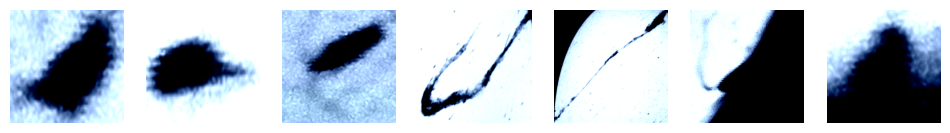

In [55]:
for flattened_image in images:
    distances = [np.linalg.norm(flattened_image - center) for center in cluster_centers]
    nearest_cluster = np.argmin(distances)
    if nearest_cluster not in cluster_images:
        cluster_images[nearest_cluster] = []
    cluster_images[nearest_cluster].append(flattened_image)

# Select one representative image from each cluster and reshape them
representative_images = []
for cluster_id, images_in_cluster in cluster_images.items():
    flattened_representative_image = images_in_cluster[6]  # Select the flattened image from the cluster
    original_shape = (3,400,400)  # Provide the original dimensions of the images
    representative_image = flattened_representative_image.reshape(original_shape)
    representative_images.append(representative_image)

# Display the representative images from each cluster
fig, axes = plt.subplots(1, len(representative_images), figsize=(12, 4))
for i, image in enumerate(representative_images):
    ax = axes[i]
    image = image.squeeze().numpy()
    ax.imshow(image.transpose(1,2,0))
    ax.axis('off')

plt.show()

/tmp/ipykernel_21278/1394020363.py:13: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  selected_images = np.random.choice(images_in_cluster, num_images_per_cluster, replace=False)
/tmp/ipykernel_21278/1394020363.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  selected_images = np.random.choice(images_in_cluster, num_images_per_cluster, replace=False)
Clipping inp

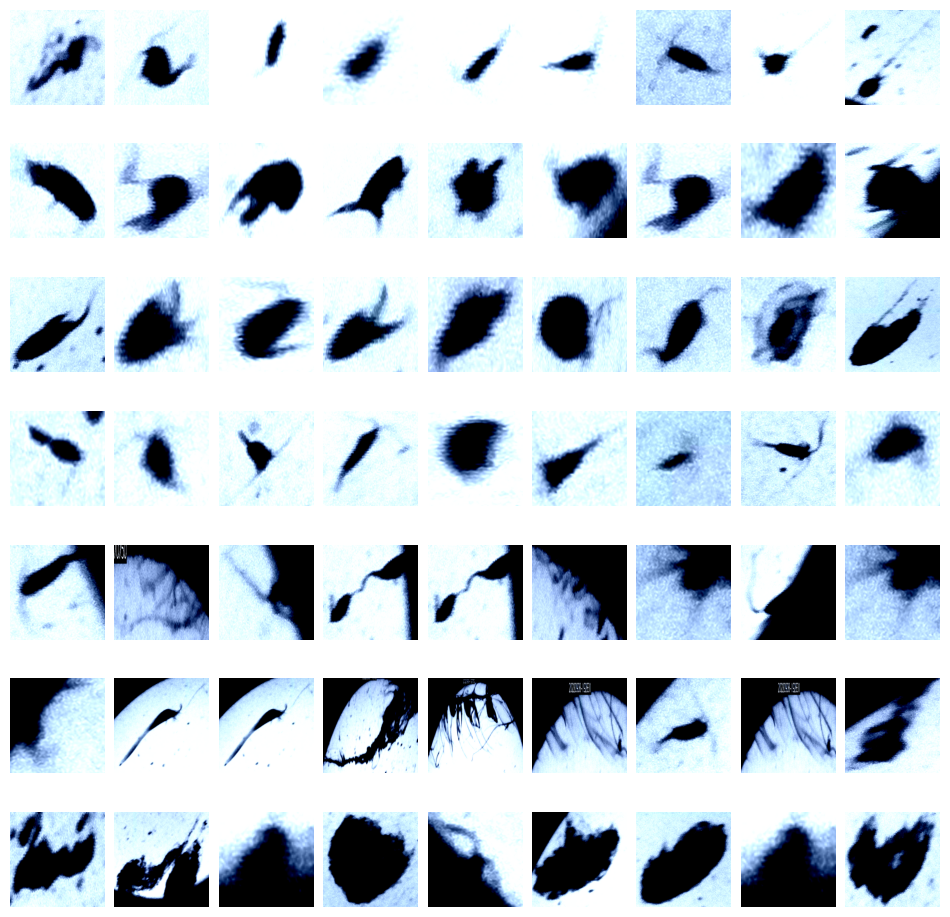

In [58]:
for flattened_image in images:
    distances = [np.linalg.norm(flattened_image - center) for center in cluster_centers]
    nearest_cluster = np.argmin(distances)
    if nearest_cluster not in cluster_images:
        cluster_images[nearest_cluster] = []
    cluster_images[nearest_cluster].append(flattened_image)

# Print 9 images from each cluster
num_images_per_cluster = 9
fig, axes = plt.subplots(len(cluster_images), num_images_per_cluster, figsize=(12, 12))

for cluster_id, images_in_cluster in cluster_images.items():
    selected_images = np.random.choice(images_in_cluster, num_images_per_cluster, replace=False)

    for i, image in enumerate(selected_images):
        ax = axes[cluster_id][i]
        image = image.reshape(3,400,400)
        image = image.squeeze().numpy()
        ax.imshow(image.transpose(1,2,0))
        ax.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

In [6]:
pip install torchviz

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=6f9ab85d1bde4a8b700504dc79b1381c85ca15c7f5ebe94dde0ffb00cecdd08b
  Stored in directory: /home/ec2-user/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz
Note: you may need to restart the kernel to use updated packages.


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x

# Create an instance of your model
model = Model_v2(dropout=0.5)

# Generate a dummy input tensor with the appropriate shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Create a visualization of the model's forward pass
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the visualization as an image file (e.g., PNG)
dot.format = 'png'
dot.render("model_visualization", format='png')


'model_visualization.png'

In [8]:
pip install torchsummary graphviz


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from graphviz import Digraph

class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x

# Create an instance of your model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model_v2(dropout=0.5).to(device)

# Generate a dummy input tensor on the same device
dummy_input = torch.randn(1, 3, 256, 256).to(device)

# Print the summary of the model architecture
summary(model, input_size=(3, 256, 256))

# Create a graph visualization of the model architecture
dot = Digraph(comment='Model Architecture')
# ... (same as before)

# Render the graph visualization as a PNG image
dot.format = 'png'
dot.render("model_architecture")

# Open the rendered PNG image and display it
image = Image.open("model_architecture.png")
image.show()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 254, 254]             448
           Dropout-2         [-1, 16, 254, 254]               0
         MaxPool2d-3         [-1, 16, 127, 127]               0
            Conv2d-4         [-1, 32, 125, 125]           4,640
           Dropout-5         [-1, 32, 125, 125]               0
         MaxPool2d-6           [-1, 32, 62, 62]               0
            Conv2d-7           [-1, 64, 60, 60]          18,496
           Dropout-8           [-1, 64, 60, 60]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
           Linear-10                  [-1, 256]      14,745,856
          Dropout-11                  [-1, 256]               0
           Linear-12                   [-1, 84]          21,588
          Dropout-13                   [-1, 84]               0
           Linear-14                   

In [13]:
pip install torch torchviz graphviz


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchviz import make_dot

class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x

# Create an instance of your model
model = Model_v2(dropout=0.5)

# Generate a dummy input tensor with the appropriate shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Create a visualization of the model's forward pass
dot = make_dot(model(dummy_input), params=dict(model.named_parameters()))

# Save the visualization as a PNG image
dot.format = 'png'
dot.render("model_visualization")

print("Model visualization saved as 'model_visualization.png'")


Model visualization saved as 'model_visualization.png'


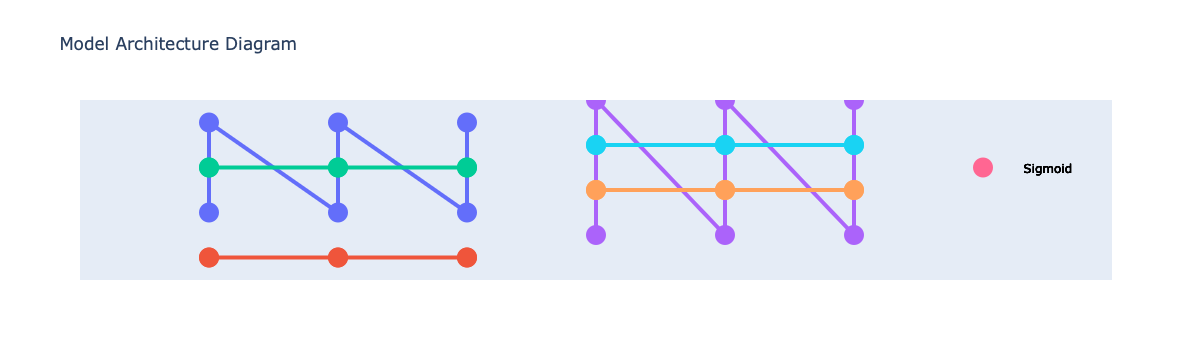

In [16]:
import plotly.graph_objects as go

# Create a figure for the model architecture diagram
fig = go.Figure()

# Add convolutional and pooling layers as blocks
fig.add_trace(go.Scatter(x=[1, 1, 2, 2, 3, 3], y=[3, 7, 3, 7, 3, 7], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))
fig.add_trace(go.Scatter(x=[1, 1, 2, 2, 3, 3], y=[1, 1, 1, 1, 1, 1], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))
fig.add_trace(go.Scatter(x=[1, 1, 2, 2, 3, 3], y=[5, 5, 5, 5, 5, 5], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))

# Add fully connected layers as blocks
fig.add_trace(go.Scatter(x=[4, 4, 5, 5, 6, 6], y=[2, 8, 2, 8, 2, 8], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))
fig.add_trace(go.Scatter(x=[4, 4, 5, 5, 6, 6], y=[4, 4, 4, 4, 4, 4], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))
fig.add_trace(go.Scatter(x=[4, 4, 5, 5, 6, 6], y=[6, 6, 6, 6, 6, 6], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))

# Add the output layer as a block
fig.add_trace(go.Scatter(x=[7], y=[5], mode="markers+lines", marker=dict(size=20), line=dict(width=4)))

# Define the text labels for the layers
layer_labels = ["Convolutional", "Pooling", "Fully Connected", "Output"]
y_positions = [1, 3, 5, 7]

# Add text labels to the blocks
for i, label in enumerate(layer_labels):
    fig.add_annotation(
        x=7.5,
        y=y_positions[i],
        xref="x",
        yref="y",
        text=label,
        showarrow=False,
        font=dict(size=12, color="black"),
    )

# Set layout properties
fig.update_layout(
    title="Model Architecture Diagram",
    xaxis=dict(
        range=[0, 8],
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    yaxis=dict(
        range=[0, 8],
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=False,
    ),
    showlegend=False,
    annotations=[
        dict(
            x=7.5,
            y=5,
            xref="x",
            yref="y",
            text="Sigmoid",
            showarrow=False,
            font=dict(size=12, color="black"),
        ),
    ],
)

# Show the figure
fig.show()


In [30]:
import torchviz

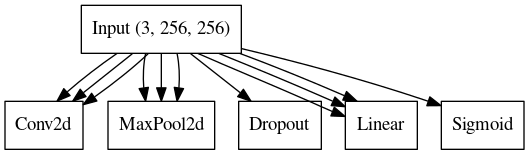

In [33]:
import torch
import torch.nn as nn


class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x


# Create an instance of your model
model = Model_v2(dropout=0.5)

# Generate a dummy input tensor with the appropriate shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Create a graph visualization of the model architecture using graphviz
dot = Digraph(comment='Model Architecture')
dot.node('input', 'Input (3, 256, 256)', shape='box')

# Add layers to the graph
for layer in model.children():
    layer_name = layer.__class__.__name__
    dot.node(layer_name, layer_name, shape='box')
    dot.edge('input', layer_name)

# Render the graph visualization as a PNG image
dot.format = 'png'
dot.render("model_architecture")

# Display the rendered PNG image (only works if you have a display in your SageMaker environment)
image = Image.open("model_architecture.png")
image.show()

In [36]:
!pip install graphviz


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [41]:
import torch
import torch.nn as nn


class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x

# Create an instance of your model
model = Model_v2(dropout=0.5)

# Generate a dummy input tensor with the appropriate shape (batch_size, channels, height, width)
dummy_input = torch.randn(1, 3, 256, 256)

# Create a visualization of the model architecture using torchviz
output = model(dummy_input)
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization as a file (e.g., PDF)
dot.format = 'pdf'
dot.render("model_architecture", view=False)


'model_architecture.pdf'

In [4]:
pip install git+https://github.com/szagoruyko/pytorchviz


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
  Cloning https://github.com/szagoruyko/pytorchviz to /tmp/pip-req-build-eg1pp_41
  Running command git clone --filter=blob:none --quiet https://github.com/szagoruyko/pytorchviz /tmp/pip-req-build-eg1pp_41
  Resolved https://github.com/szagoruyko/pytorchviz to commit 0adcd83af8aa7ab36d6afd139cabbd9df598edb7
  Preparing metadata (setup.py) ... done
Note: you may need to restart the kernel to use updated packages.


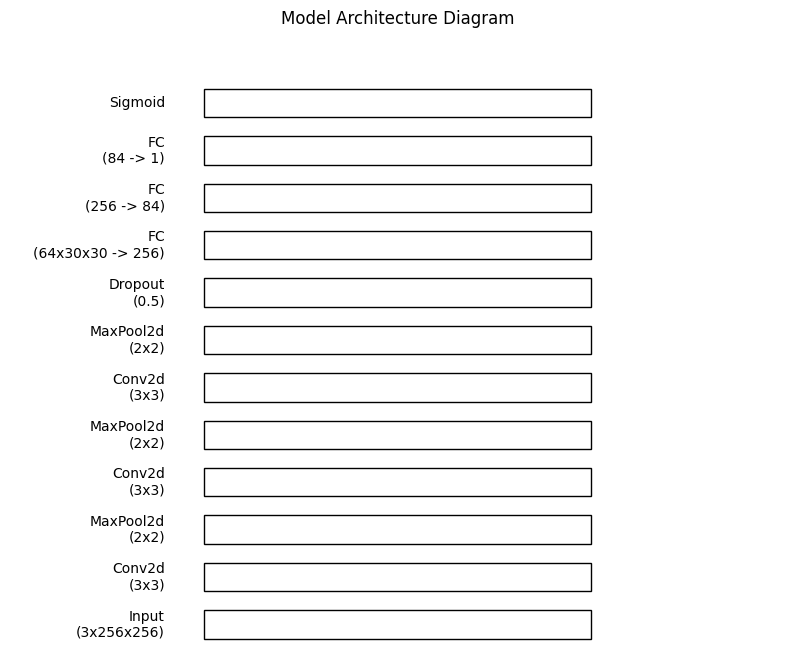

In [15]:
import matplotlib.pyplot as plt
import numpy as np

class Model_v2(nn.Module):
    def __init__(self, dropout):
        super(Model_v2, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 2)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout)
        
        # Adjusting the fully connected layers to fit the spatial dimensions
        # of the input image (256x256)
        self.fc1 = nn.Linear(64 * 30 * 30, 256)
        self.fc2 = nn.Linear(256, 84)
        self.fc3 = nn.Linear(84, 1)  # Output layer for binary classification (1 neuron for probability)
        self.sigmoid = nn.Sigmoid()  # Sigmoid activation for probability output
        
    def forward(self, x):
        x = self.dropout(F.relu(self.conv1(x)))
        x = self.pool1(x)
        x = self.dropout(F.relu(self.conv2(x)))
        x = self.pool2(x)
        x = self.dropout(F.relu(self.conv3(x)))
        x = self.pool3(x)
        x = x.view(-1, 64 * 30 * 30)  # Adjusted view shape
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.sigmoid(self.fc3(x))  # Use sigmoid activation for probability output
        return x
# Create an instance of your model
model = Model_v2(dropout=0.5)

# Create a random input image (batch size = 1, 3 channels, 256x256 image)
dummy_input = torch.randn(1, 3, 256, 256)

# Function to add a layer block to the diagram
def add_layer(ax, text, num_layers):
    ax.text(-0.1, num_layers, text, fontsize=10, ha="right", va="center")
    ax.add_patch(plt.Rectangle((0, num_layers - 0.3), 1, 0.6, fill=False, edgecolor='black'))

# Create the diagram
fig, ax = plt.subplots(figsize=(10, 8))

num_layers = 0

# Input layer
add_layer(ax, "Input\n(3x256x256)", num_layers)
num_layers += 1

# Convolutional and MaxPool layers
for _ in range(3):
    add_layer(ax, f"Conv2d\n(3x3)", num_layers)
    num_layers += 1
    add_layer(ax, f"MaxPool2d\n(2x2)", num_layers)
    num_layers += 1

# Dropout layer
add_layer(ax, f"Dropout\n(0.5)", num_layers)
num_layers += 1

# Fully connected layers
add_layer(ax, f"FC\n(64x30x30 -> 256)", num_layers)
num_layers += 1
add_layer(ax, f"FC\n(256 -> 84)", num_layers)
num_layers += 1

# Output layer
add_layer(ax, f"FC\n(84 -> 1)", num_layers)
num_layers += 1
add_layer(ax, "Sigmoid", num_layers)
num_layers += 1

# Set diagram properties
ax.set_xlim(-0.5, 1.5)
ax.set_ylim(-0.5, num_layers + 0.5)
ax.axis('off')
plt.title("Model Architecture Diagram")

plt.show()


In [6]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

def init_conv_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class UNet(nn.Module):
    def __init__(self, input_channels=3, start_neurons=16, dropout_rate=0.0):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(input_channels, start_neurons, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(start_neurons)
        self.conv1_1 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(start_neurons)
        self.pool1 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout1 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv2 = nn.Conv2d(start_neurons, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv2_1 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.pool2 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout2 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv3 = nn.Conv2d(start_neurons * 2, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv3_1 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.pool3 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout3 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv4 = nn.Conv2d(start_neurons * 4, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv4_1 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.pool4 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout4 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Middle
        self.middle_conv1 = nn.Conv2d(start_neurons * 8, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.middle_conv1_1 = nn.Conv2d(start_neurons * 16, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.dropout_middle = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Decoder
        self.deconv4 = nn.ConvTranspose2d(start_neurons * 16, start_neurons * 8, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up4_1 = nn.Conv2d(start_neurons * 16, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv_up4_2 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_2_bn = nn.BatchNorm2d(start_neurons * 8)

        self.deconv3 = nn.ConvTranspose2d(start_neurons * 8, start_neurons * 4, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up3_1 = nn.Conv2d(start_neurons * 8, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv_up3_2 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_2_bn = nn.BatchNorm2d(start_neurons * 4)

        self.deconv2 = nn.ConvTranspose2d(start_neurons * 4, start_neurons * 2, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up2_1 = nn.Conv2d(start_neurons * 4, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv_up2_2 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_2_bn = nn.BatchNorm2d(start_neurons * 2)

        self.deconv1 = nn.ConvTranspose2d(start_neurons * 2, start_neurons, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up1_1 = nn.Conv2d(start_neurons * 2, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_1_bn = nn.BatchNorm2d(start_neurons)
        self.conv_up1_2 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_2_bn = nn.BatchNorm2d(start_neurons)

        # Output layer
        self.output_layer = nn.Conv2d(start_neurons, 1, kernel_size=1)

        # Initialize weights with identity matrices
        self.apply(init_conv_weights)

    def forward(self, x):
        # Encoder
        conv1 = nn.ReLU(inplace=True)(self.conv1_bn(self.conv1(x)))
        conv1 = nn.ReLU(inplace=True)(self.conv1_1_bn(self.conv1_1(conv1)))
        pool1 = self.pool1(conv1)
        pool1 = self.dropout1(pool1)  # Dropout added

        conv2 = nn.ReLU(inplace=True)(self.conv2_bn(self.conv2(pool1)))
        conv2 = nn.ReLU(inplace=True)(self.conv2_1_bn(self.conv2_1(conv2)))
        pool2 = self.pool2(conv2)
        pool2 = self.dropout2(pool2)  # Dropout added

        conv3 = nn.ReLU(inplace=True)(self.conv3_bn(self.conv3(pool2)))
        conv3 = nn.ReLU(inplace=True)(self.conv3_1_bn(self.conv3_1(conv3)))
        pool3 = self.pool3(conv3)
        pool3 = self.dropout3(pool3)  # Dropout added

        conv4 = nn.ReLU(inplace=True)(self.conv4_bn(self.conv4(pool3)))
        conv4 = nn.ReLU(inplace=True)(self.conv4_1_bn(self.conv4_1(conv4)))
        pool4 = self.pool4(conv4)
        pool4 = self.dropout4(pool4)  # Dropout added

        # Middle
        middle = nn.ReLU(inplace=True)(self.middle_conv1_bn(self.middle_conv1(pool4)))
        middle = nn.ReLU(inplace=True)(self.middle_conv1_1_bn(self.middle_conv1_1(middle)))
        middle = self.dropout_middle(middle)  # Dropout added

        # Decoder
        deconv4 = self.deconv4(middle)
        concat4 = torch.cat([deconv4, conv4], dim=1)
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_1_bn(self.conv_up4_1(concat4)))
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_2_bn(self.conv_up4_2(conv_up4)))

        deconv3 = self.deconv3(conv_up4)
        concat3 = torch.cat([deconv3, conv3], dim=1)
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_1_bn(self.conv_up3_1(concat3)))
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_2_bn(self.conv_up3_2(conv_up3)))

        deconv2 = self.deconv2(conv_up3)
        concat2 = torch.cat([deconv2, conv2], dim=1)
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_1_bn(self.conv_up2_1(concat2)))
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_2_bn(self.conv_up2_2(conv_up2)))

        deconv1 = self.deconv1(conv_up2)
        concat1 = torch.cat([deconv1, conv1], dim=1)
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_1_bn(self.conv_up1_1(concat1)))
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_2_bn(self.conv_up1_2(conv_up1)))

        # Output layer
        output = self.output_layer(conv_up1)

        return output


# Create an instance of your model
model = UNet(input_channels=3, start_neurons=16, dropout_rate=0.1)

# Create a random input image (batch size = 1, 3 channels, 256x256 image)
dummy_input = torch.randn(1, 3, 500, 500)

# Function to add a layer block to the diagram
def add_layer(ax, text, num_layers):
    ax.text(0.5, 1 - (num_layers * 0.15), text, fontsize=10, ha="center", va="center",
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2'))


In [9]:
import torch
import torch.nn as nn
from torchviz import make_dot

def init_conv_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class UNet(nn.Module):
    def __init__(self, input_channels=3, start_neurons=16, dropout_rate=0.0):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(input_channels, start_neurons, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(start_neurons)
        self.conv1_1 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(start_neurons)
        self.pool1 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout1 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv2 = nn.Conv2d(start_neurons, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv2_1 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.pool2 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout2 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv3 = nn.Conv2d(start_neurons * 2, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv3_1 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.pool3 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout3 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv4 = nn.Conv2d(start_neurons * 4, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv4_1 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.pool4 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout4 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Middle
        self.middle_conv1 = nn.Conv2d(start_neurons * 8, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.middle_conv1_1 = nn.Conv2d(start_neurons * 16, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.dropout_middle = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Decoder
        self.deconv4 = nn.ConvTranspose2d(start_neurons * 16, start_neurons * 8, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up4_1 = nn.Conv2d(start_neurons * 16, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv_up4_2 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_2_bn = nn.BatchNorm2d(start_neurons * 8)

        self.deconv3 = nn.ConvTranspose2d(start_neurons * 8, start_neurons * 4, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up3_1 = nn.Conv2d(start_neurons * 8, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv_up3_2 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_2_bn = nn.BatchNorm2d(start_neurons * 4)

        self.deconv2 = nn.ConvTranspose2d(start_neurons * 4, start_neurons * 2, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up2_1 = nn.Conv2d(start_neurons * 4, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv_up2_2 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_2_bn = nn.BatchNorm2d(start_neurons * 2)

        self.deconv1 = nn.ConvTranspose2d(start_neurons * 2, start_neurons, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up1_1 = nn.Conv2d(start_neurons * 2, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_1_bn = nn.BatchNorm2d(start_neurons)
        self.conv_up1_2 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_2_bn = nn.BatchNorm2d(start_neurons)

        # Output layer
        self.output_layer = nn.Conv2d(start_neurons, 1, kernel_size=1)

        # Initialize weights with identity matrices
        self.apply(init_conv_weights)

    def forward(self, x):
        # Encoder
        conv1 = nn.ReLU(inplace=True)(self.conv1_bn(self.conv1(x)))
        conv1 = nn.ReLU(inplace=True)(self.conv1_1_bn(self.conv1_1(conv1)))
        pool1 = self.pool1(conv1)
        pool1 = self.dropout1(pool1)  # Dropout added

        conv2 = nn.ReLU(inplace=True)(self.conv2_bn(self.conv2(pool1)))
        conv2 = nn.ReLU(inplace=True)(self.conv2_1_bn(self.conv2_1(conv2)))
        pool2 = self.pool2(conv2)
        pool2 = self.dropout2(pool2)  # Dropout added

        conv3 = nn.ReLU(inplace=True)(self.conv3_bn(self.conv3(pool2)))
        conv3 = nn.ReLU(inplace=True)(self.conv3_1_bn(self.conv3_1(conv3)))
        pool3 = self.pool3(conv3)
        pool3 = self.dropout3(pool3)  # Dropout added

        conv4 = nn.ReLU(inplace=True)(self.conv4_bn(self.conv4(pool3)))
        conv4 = nn.ReLU(inplace=True)(self.conv4_1_bn(self.conv4_1(conv4)))
        pool4 = self.pool4(conv4)
        pool4 = self.dropout4(pool4)  # Dropout added

        # Middle
        middle = nn.ReLU(inplace=True)(self.middle_conv1_bn(self.middle_conv1(pool4)))
        middle = nn.ReLU(inplace=True)(self.middle_conv1_1_bn(self.middle_conv1_1(middle)))
        middle = self.dropout_middle(middle)  # Dropout added

        # Decoder
        deconv4 = self.deconv4(middle)
        concat4 = torch.cat([deconv4, conv4], dim=1)
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_1_bn(self.conv_up4_1(concat4)))
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_2_bn(self.conv_up4_2(conv_up4)))

        deconv3 = self.deconv3(conv_up4)
        concat3 = torch.cat([deconv3, conv3], dim=1)
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_1_bn(self.conv_up3_1(concat3)))
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_2_bn(self.conv_up3_2(conv_up3)))

        deconv2 = self.deconv2(conv_up3)
        concat2 = torch.cat([deconv2, conv2], dim=1)
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_1_bn(self.conv_up2_1(concat2)))
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_2_bn(self.conv_up2_2(conv_up2)))

        deconv1 = self.deconv1(conv_up2)
        concat1 = torch.cat([deconv1, conv1], dim=1)
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_1_bn(self.conv_up1_1(concat1)))
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_2_bn(self.conv_up1_2(conv_up1)))

        # Output layer
        output = self.output_layer(conv_up1)

        return output

model = UNet(input_channels=3, start_neurons=16, dropout_rate=0.1)

# Create a dummy input tensor (adjust the shape as needed)
dummy_input = torch.randn(1, 3, 512, 512)  # Batch size of 1, 3 channels, 256x256 image

# Forward pass to generate the computation graph
output = model(dummy_input)

# Generate the visualization
dot = make_dot(output, params=dict(model.named_parameters()))

# Save the visualization to a file (e.g., in 'png' format)
dot.render("unet_graph", format="png")


'unet_graph.png'

In [24]:
import torch
import torch.nn as nn
import graphviz


def init_conv_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

class UNet(nn.Module):
    def __init__(self, input_channels=3, start_neurons=16, dropout_rate=0.0):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(input_channels, start_neurons, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(start_neurons)
        self.conv1_1 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(start_neurons)
        self.pool1 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout1 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv2 = nn.Conv2d(start_neurons, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv2_1 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.pool2 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout2 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv3 = nn.Conv2d(start_neurons * 2, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv3_1 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.pool3 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout3 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        self.conv4 = nn.Conv2d(start_neurons * 4, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv4_1 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.pool4 = nn.MaxPool2d(4, 4)  # Updated kernel_size and stride
        self.dropout4 = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Middle
        self.middle_conv1 = nn.Conv2d(start_neurons * 8, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.middle_conv1_1 = nn.Conv2d(start_neurons * 16, start_neurons * 16, kernel_size=3, padding=1)
        self.middle_conv1_1_bn = nn.BatchNorm2d(start_neurons * 16)
        self.dropout_middle = nn.Dropout2d(p=dropout_rate)  # Dropout layer added

        # Decoder
        self.deconv4 = nn.ConvTranspose2d(start_neurons * 16, start_neurons * 8, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up4_1 = nn.Conv2d(start_neurons * 16, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_1_bn = nn.BatchNorm2d(start_neurons * 8)
        self.conv_up4_2 = nn.Conv2d(start_neurons * 8, start_neurons * 8, kernel_size=3, padding=1)
        self.conv_up4_2_bn = nn.BatchNorm2d(start_neurons * 8)

        self.deconv3 = nn.ConvTranspose2d(start_neurons * 8, start_neurons * 4, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up3_1 = nn.Conv2d(start_neurons * 8, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_1_bn = nn.BatchNorm2d(start_neurons * 4)
        self.conv_up3_2 = nn.Conv2d(start_neurons * 4, start_neurons * 4, kernel_size=3, padding=1)
        self.conv_up3_2_bn = nn.BatchNorm2d(start_neurons * 4)

        self.deconv2 = nn.ConvTranspose2d(start_neurons * 4, start_neurons * 2, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up2_1 = nn.Conv2d(start_neurons * 4, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_1_bn = nn.BatchNorm2d(start_neurons * 2)
        self.conv_up2_2 = nn.Conv2d(start_neurons * 2, start_neurons * 2, kernel_size=3, padding=1)
        self.conv_up2_2_bn = nn.BatchNorm2d(start_neurons * 2)

        self.deconv1 = nn.ConvTranspose2d(start_neurons * 2, start_neurons, kernel_size=4, stride=4)  # Updated kernel_size and stride
        self.conv_up1_1 = nn.Conv2d(start_neurons * 2, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_1_bn = nn.BatchNorm2d(start_neurons)
        self.conv_up1_2 = nn.Conv2d(start_neurons, start_neurons, kernel_size=3, padding=1)
        self.conv_up1_2_bn = nn.BatchNorm2d(start_neurons)

        # Output layer
        self.output_layer = nn.Conv2d(start_neurons, 1, kernel_size=1)

        # Initialize weights with identity matrices
        self.apply(init_conv_weights)

    def forward(self, x):
        # Encoder
        conv1 = nn.ReLU(inplace=True)(self.conv1_bn(self.conv1(x)))
        conv1 = nn.ReLU(inplace=True)(self.conv1_1_bn(self.conv1_1(conv1)))
        pool1 = self.pool1(conv1)
        pool1 = self.dropout1(pool1)  # Dropout added

        conv2 = nn.ReLU(inplace=True)(self.conv2_bn(self.conv2(pool1)))
        conv2 = nn.ReLU(inplace=True)(self.conv2_1_bn(self.conv2_1(conv2)))
        pool2 = self.pool2(conv2)
        pool2 = self.dropout2(pool2)  # Dropout added

        conv3 = nn.ReLU(inplace=True)(self.conv3_bn(self.conv3(pool2)))
        conv3 = nn.ReLU(inplace=True)(self.conv3_1_bn(self.conv3_1(conv3)))
        pool3 = self.pool3(conv3)
        pool3 = self.dropout3(pool3)  # Dropout added

        conv4 = nn.ReLU(inplace=True)(self.conv4_bn(self.conv4(pool3)))
        conv4 = nn.ReLU(inplace=True)(self.conv4_1_bn(self.conv4_1(conv4)))
        pool4 = self.pool4(conv4)
        pool4 = self.dropout4(pool4)  # Dropout added

        # Middle
        middle = nn.ReLU(inplace=True)(self.middle_conv1_bn(self.middle_conv1(pool4)))
        middle = nn.ReLU(inplace=True)(self.middle_conv1_1_bn(self.middle_conv1_1(middle)))
        middle = self.dropout_middle(middle)  # Dropout added

        # Decoder
        deconv4 = self.deconv4(middle)
        concat4 = torch.cat([deconv4, conv4], dim=1)
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_1_bn(self.conv_up4_1(concat4)))
        conv_up4 = nn.ReLU(inplace=True)(self.conv_up4_2_bn(self.conv_up4_2(conv_up4)))

        deconv3 = self.deconv3(conv_up4)
        concat3 = torch.cat([deconv3, conv3], dim=1)
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_1_bn(self.conv_up3_1(concat3)))
        conv_up3 = nn.ReLU(inplace=True)(self.conv_up3_2_bn(self.conv_up3_2(conv_up3)))

        deconv2 = self.deconv2(conv_up3)
        concat2 = torch.cat([deconv2, conv2], dim=1)
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_1_bn(self.conv_up2_1(concat2)))
        conv_up2 = nn.ReLU(inplace=True)(self.conv_up2_2_bn(self.conv_up2_2(conv_up2)))

        deconv1 = self.deconv1(conv_up2)
        concat1 = torch.cat([deconv1, conv1], dim=1)
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_1_bn(self.conv_up1_1(concat1)))
        conv_up1 = nn.ReLU(inplace=True)(self.conv_up1_2_bn(self.conv_up1_2(conv_up1)))

        # Output layer
        output = self.output_layer(conv_up1)

        return output


model = UNet(input_channels=3, start_neurons=16, dropout_rate=0.1)

# Create a dummy input tensor (adjust the shape as needed)

# Create a dummy input tensor (adjust the shape as needed)
dummy_input = torch.randn(1, 3, 512, 512)  # Batch size of 1, 3 channels, 512x512 image

# Forward pass to build the graph
output = model(dummy_input)

# Create a Graphviz Digraph
dot = graphviz.Digraph(format='png')

# Define the nodes for each layer
layers = list(model.children())
for layer_idx, layer in enumerate(layers):
    layer_type = str(layer.__class__).split(".")[-1].split("'")[0]
    num_units = sum(p.numel() for p in layer.parameters())
    dot.node(f"layer_{layer_idx}", f"{layer_type}\n{num_units} params")

# Define the edges between layers
for i in range(len(layers) - 1):
    dot.edge(f"layer_{i}", f"layer_{i + 1}")

# Save the graph to a file
dot.render('unet_graph', view=False)


'unet_graph.png'

In [17]:
pip install hiddenlayer


Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Note: you may need to restart the kernel to use updated packages.


/home/ec2-user/anaconda3/envs/amazonei_pytorch_latest_p37/lib/python3.7/site-packages/torch/onnx/symbolic_helper.py:176: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


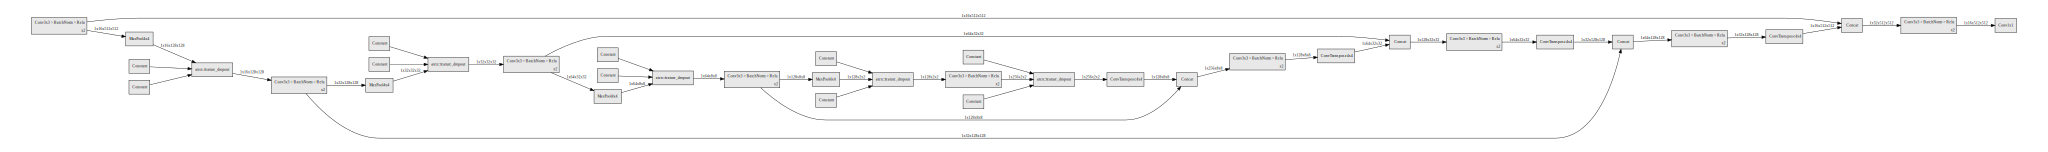

In [18]:
import torch
import torch.nn as nn
import hiddenlayer as hl

# Your UNet class definition here...

model = UNet(input_channels=3, start_neurons=16, dropout_rate=0.1)

# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 512, 512)  # Batch size of 1, 3 channels, 512x512 image

# Visualize the model architecture
hl.build_graph(model, dummy_input)


In [26]:
digraph NeuralNetwork{
    node [shape=box, style="filled, rounded", color="lightgray"];
    
    layer_0 [label="Conv2d\n448 params"];
    layer_1 [label="BatchNorm2d\n32 params"];
    layer_2 [label="Conv2d\n2320 params"];
    layer_3 [label="BatchNorm2d\n32 params"];
    layer_4 [label="MaxPool2d\n0 params"];
    layer_5 [label="Dropout2d\n0 params"];
    layer_6 [label="Conv2d\n4640 params"];
    layer_7 [label="BatchNorm2d\n64 params"];
    layer_8 [label="Conv2d\n9248 params"];
    layer_9 [label="BatchNorm2d\n64 params"];
    layer_10 [label="MaxPool2d\n0 params"];
    layer_11 [label="Dropout2d\n0 params"];
    layer_12 [label="Conv2d\n18496 params"];
    layer_13 [label="BatchNorm2d\n128 params"];
    layer_14 [label="Conv2d\n36928 params"];
    layer_15 [label="BatchNorm2d\n128 params"];
    layer_16 [label="MaxPool2d\n0 params"];
    layer_17 [label="Dropout2d\n0 params"];
    layer_18 [label="Conv2d\n73856 params"];
    layer_19 [label="BatchNorm2d\n256 params"];
    layer_20 [label="Conv2d\n147584 params"];
    layer_21 [label="BatchNorm2d\n256 params"];
    layer_22 [label="MaxPool2d\n0 params"];
    layer_23 [label="Dropout2d\n0 params"];
    layer_24 [label="Conv2d\n295168 params"];
    layer_25 [label="BatchNorm2d\n512 params"];
    layer_26 [label="Conv2d\n590080 params"];
    layer_27 [label="BatchNorm2d\n512 params"];
    layer_28 [label="Dropout2d\n0 params"];
    layer_29 [label="ConvTranspose2d\n524416 params"];
    layer_30 [label="Conv2d\n295040 params"];
    layer_31 [label="BatchNorm2d\n256 params"];
    layer_32 [label="Conv2d\n147584 params"];
    layer_33 [label="BatchNorm2d\n256 params"];
    layer_34 [label="ConvTranspose2d\n131136 params"];
    layer_35 [label="Conv2d\n73792 params"];
    layer_36 [label="BatchNorm2d\n128 params"];
    layer_37 [label="Conv2d\n36928 params"];
    layer_38 [label="BatchNorm2d\n128 params"];
    layer_39 [label="ConvTranspose2d\n32800 params"];
    layer_40 [label="Conv2d\n18464 params"];
    layer_41 [label="BatchNorm2d\n64 params"];
    layer_42 [label="Conv2d\n9248 params"];
    layer_43 [label="BatchNorm2d\n64 params"];
    layer_44 [label="ConvTranspose2d\n8208 params"];
    layer_45 [label="Conv2d\n4624 params"];
    layer_46 [label="BatchNorm2d\n32 params"];
    layer_47 [label="Conv2d\n2320 params"];
    layer_48 [label="BatchNorm2d\n32 params"];
    layer_49 [label="Conv2d\n17 params"];

    layer_0 -> layer_1 -> layer_2 -> layer_3 -> layer_4 -> layer_5 -> layer_6 -> layer_7 -> layer_8 -> layer_9 -> layer_10 -> layer_11 -> layer_12 -> layer_13 -> layer_14 -> layer_15 -> layer_16 -> layer_17 -> layer_18 -> layer_19 -> layer_20 -> layer_21 -> layer_22 -> layer_23 -> layer_24 -> layer_25 -> layer_26 -> layer_27 -> layer_28 -> layer_29 -> layer_30 -> layer_31 -> layer_32 -> layer_33 -> layer_34 -> layer_35 -> layer_36 -> layer_37 -> layer_38 -> layer_39 -> layer_40 -> layer_41 -> layer_42 -> layer_43 -> layer_44 -> layer_45 -> layer_46 -> layer_47 -> layer_48 -> layer_49;
}


SyntaxError: invalid syntax (2667423390.py, line 1)